# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")


New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [27]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
import torch
import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from sklearn.model_selection import KFold

# Image Processing and Feature Extraction
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras
from PIL import Image

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy
import cv2

# 2) Functions

## Image functions

In [3]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region

def plot_sample_image(index, dataset):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))

    for i in range(3):
        imagen, label = dataset.__getitem__(index)
        imagen = np.swapaxes(imagen, 0, 2)
        label = convert_to_text(label)
        axes[i].imshow(imagen)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Training functions

In [4]:
def train_one_epoch(model, optimizer, data_loader, device, dtype=torch.float32, scaler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples

def accuracy(loader, model, device, dtype=torch.float32):
    print(f'Checking accuracy on {"validation" if loader.dataset.train else "test"} set')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy

# Función para inicializar los modelos pre-entrenados
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
    else:
        raise ValueError('Modelo no reconocido, elige entre vgg16, resnet50, inceptionv3 o mobilenetv2')
    
    return model



## Dataset functions

In [5]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels):
        self.img_labels = labels
        self.img_dir = img_dir
        self.transform = T.Compose([
            T.Pad(100, padding_mode='reflect'),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=(-10, 10), fill=100),
            T.Resize((400, 400)),  # Ajustamos el redimensionamiento para un valor más cercano a 300x300
            T.CenterCrop(300),  # Aplicamos un recorte al tamaño final deseado
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 1) + '.BMP')
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        label = int(self.img_labels[idx])

        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label


## Utility functions

In [6]:
def convert_to_number(x):
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2
    
def convert_to_text(numeric_value):
    """
    Converts a numeric value to its corresponding label.

    Parameters:
    - numeric_value (int): Input numeric value.

    Returns:
    - str: Label corresponding to the input numeric value.
    """
    if numeric_value == 0:
        return 'A'
    if numeric_value == 1:
        return 'B'
    if numeric_value == 2:
        return 'C'

    
def choose_region(zone, n_data, blast_quality):
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)

  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert_to_number(blast_quality[i-1][1])
    y_TE[i-1] = convert_to_number(blast_quality[i-1][2])
    y_ZP[i-1] = convert_to_number(blast_quality[i-1][0])

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return y_data
    

# 3) Load dataset

## Load labels

In [7]:
n_data = 250
region = 'ICM'
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,n_data+1):
    blast_quality.append(list(sheet['B'+str(i)].value))

y = choose_region(region, n_data, blast_quality)

## Build dataset

In [8]:
img_dir = 'data/BlastsOnline/Images'

EmbryoDatasetICM = EmbryoDataset(img_dir, y)

# 4) Plot samples

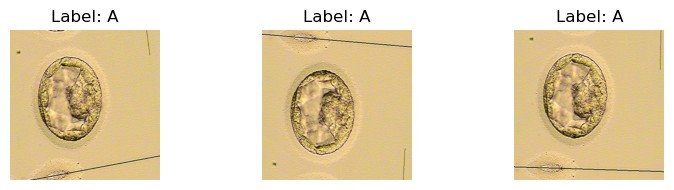

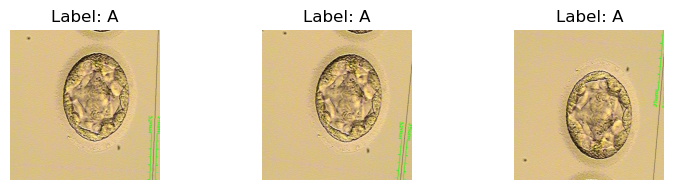

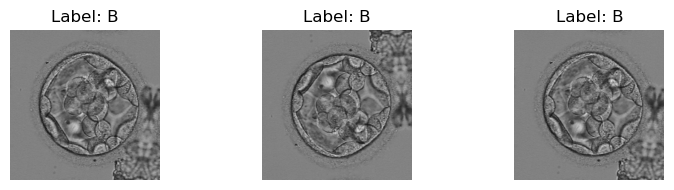

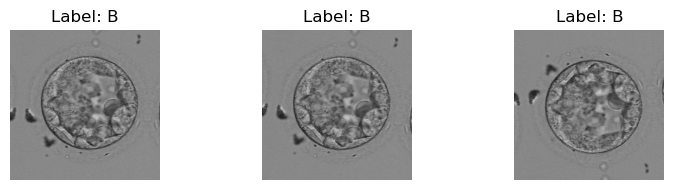

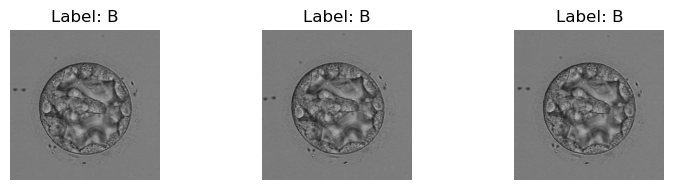

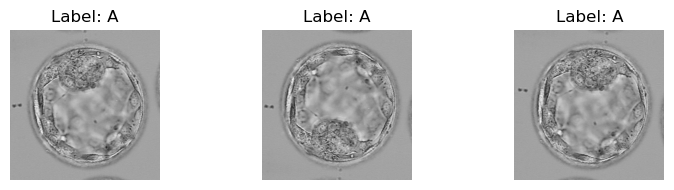

In [24]:
plot_sample_image(0, EmbryoDatasetICM)
plot_sample_image(1, EmbryoDatasetICM)
plot_sample_image(2, EmbryoDatasetICM)

# 5) Entrenamiento

## Training setup

In [12]:

# Define el número de pliegues para la validación cruzada
num_folds = 10  # Por ejemplo, utiliza 5-fold cross-validation

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 16
num_epochs = 2

# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(EmbryoDatasetICM)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    train_dataset = torch.utils.data.Subset(EmbryoDatasetICM, train_index)
    valid_dataset = torch.utils.data.Subset(EmbryoDatasetICM, val_index)

    # Crea los DataLoaders para este pliegue
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size)

    train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(val_loader, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


Fold 1/5


 46%|████▌     | 6/13 [02:02<02:23, 20.46s/it]


KeyboardInterrupt: 